In [288]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
import matplotlib.pyplot as plt
import numpy as np

# Custom code
from coordination.common.sparse_series import SparseSeries
from coordination.inference.vocalics import ContinuousCoordinationInferenceFromVocalics
from coordination.plot.coordination import plot_continuous_coordination, add_continuous_coordination_bar
from coordination.plot.vocalics import plot_vocalic_features
from coordination.synthetic.coordination_generator import ContinuousCoordinationGenerator, DiscreteCoordinationGenerator
from coordination.synthetic.vocalics_generator import VocalicsGeneratorForContinuousCoordination

## Model Definition

In this model, coordination is a continuous variable with value between 0 and 1. The existance of coordination affects the coupling between series $A$ and $B$, that is, to what extend $B_t$ depends on $A_{t-1}$ and vice versa. 

The distributions are as follows:

$
\begin{align}
p(C_0) &= \mathcal{N}_{[0,1]}(C_0; \mu_{C_0}, \sigma_{C_0}) \\
p(C_t | C_{t-1}) &= \mathcal{N}_{[0,1]}(C_t; C_{t-1}, \sigma_c)\\
p(\text{Feature}_A) = p(\text{Feature}_B) &\sim \mathcal{N}(\text{Feature}; 0, I) ~~\text{(prior)}\\
p(A_{t}|A_{t-1}, B_{t-1}, C_t) &= \mathcal{N}(A_{t};C_t f(B_{t-1}) + (1 - C_t)f(A_{t-1}), \sigma_{coupling_A}) \\
&= \mathcal{N}(A_{t};(f(B_{t-1}) - f(A_{t-1})) C_t + f(A_{t-1}), \sigma_{coupling_a}) \\
&= \mathcal{N}(A_{t};(\Delta C_t + f(A_{t-1}), \sigma_{coupling_a}) \\
p(B_{t}|B_{t-1}, A_{t-1}, C_t) &= \mathcal{N}(B_{t};C_t f(A_{t-1}) + (1 - C_t)f(B_{t-1}), \sigma_{coupling_B}) \\
&= \mathcal{N}(B_{t};(f(A_{t-1}) - f(B_{t-1})) C_t + f(B_{t-1}), \sigma_{coupling_B}) \\
&= \mathcal{N}(B_{t};(-\Delta C_t + f(B_{t-1}), \sigma_{coupling_B}) \\
\end{align}
$

To keep coordination constrained to the range 0 and 1, we use a truncated normal for the coordination drifting, prior and posterior distributions. 

This model makes a series of assumptions:

1. Coordination regulates the blending of two series: subject own previous value and other subject previous value.
2. Coordination drifts over time around it's previous value
3. We start by setting $f(.)$ to be the identity function. That means coordination is observed as a simple linear coupling betweeen the series.

In [289]:
# Constants
SEED = 0 # For reproducibility
OBSERVATION_DENSITY = 1 # Proportion of timesteps with observation
NUM_TIME_STEPS = 100
M = int(NUM_TIME_STEPS/2) # We assume coordination in the second half of the period is constant for now
NUM_FEATURES = 2

# Parameters of the distributions
MEAN_COORDINATION_PRIOR = 0; STD_COORDINATION_PRIOR = 0 # The process starts with no coordination
STD_COORDINATION_DRIFT = 0.1 # Coordination drifts by a little
MEAN_PRIOR_A = np.zeros(NUM_FEATURES)
MEAN_PRIOR_B = np.ones(NUM_FEATURES)
STD_PRIOR_A = np.ones(NUM_FEATURES)
STD_PRIOR_B = np.ones(NUM_FEATURES)
STD_COUPLING_A = np.ones(NUM_FEATURES)
STD_COUPLING_B = np.ones(NUM_FEATURES)

## Syntetic Data

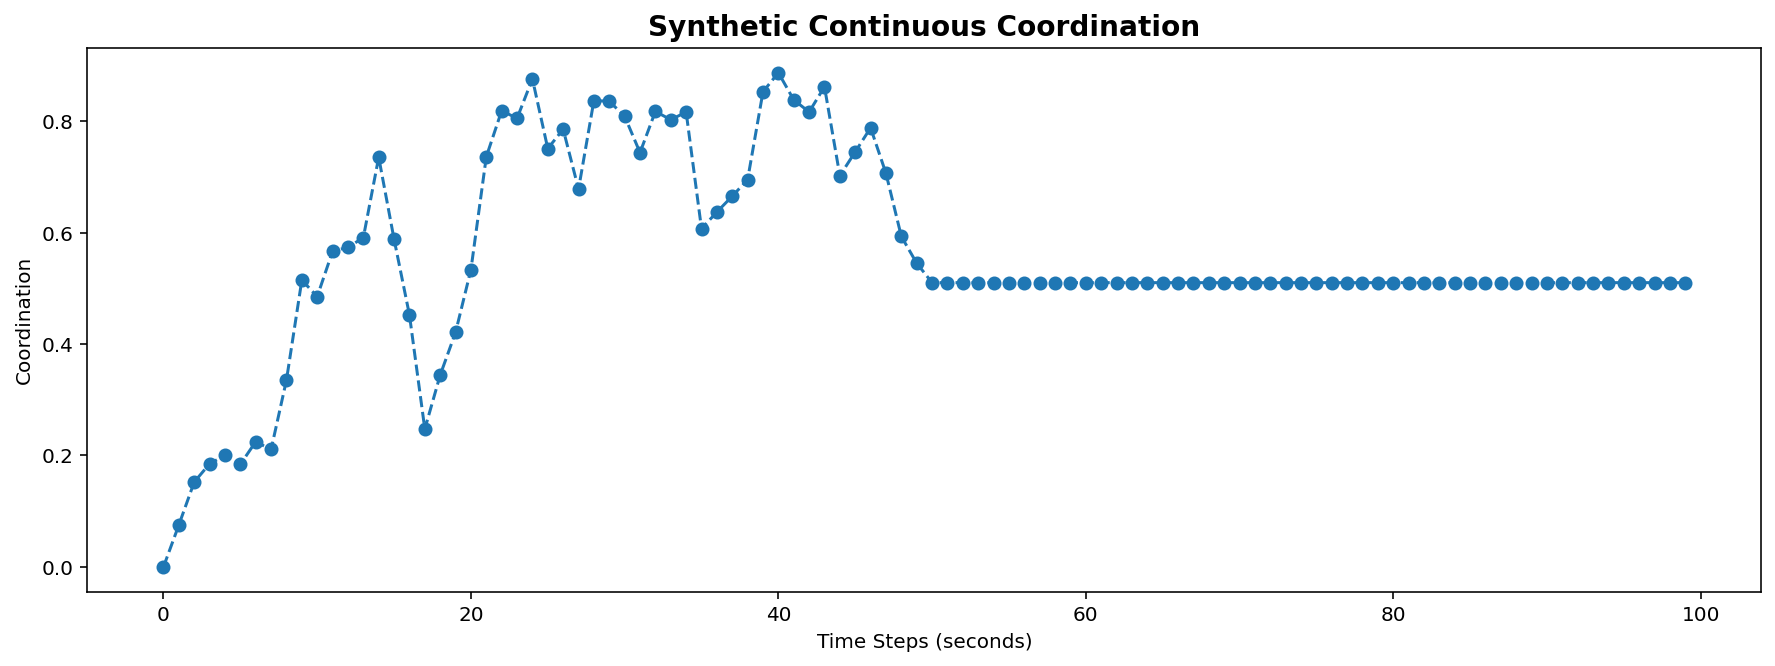

In [276]:
generator = ContinuousCoordinationGenerator(num_time_steps=NUM_TIME_STEPS, 
                                            prior_mean=MEAN_COORDINATION_PRIOR, 
                                            prior_std=STD_COORDINATION_PRIOR, 
                                            transition_std=STD_COORDINATION_DRIFT)
# generator = DiscreteCoordinationGenerator(num_time_steps=NUM_TIME_STEPS, 
#                                           p_coordinated=0, 
#                                           p_transition=0.1)
continuous_cs = generator.generate(SEED)
continuous_cs[M:] = continuous_cs[M]

fig = plt.figure(figsize=(15,5))
plot_continuous_coordination(ax=fig.gca(), 
                             coordination=continuous_cs, 
                             color="tab:blue", 
                             title="Synthetic Continuous Coordination",
                             xaxis_label="Time Steps (seconds)")

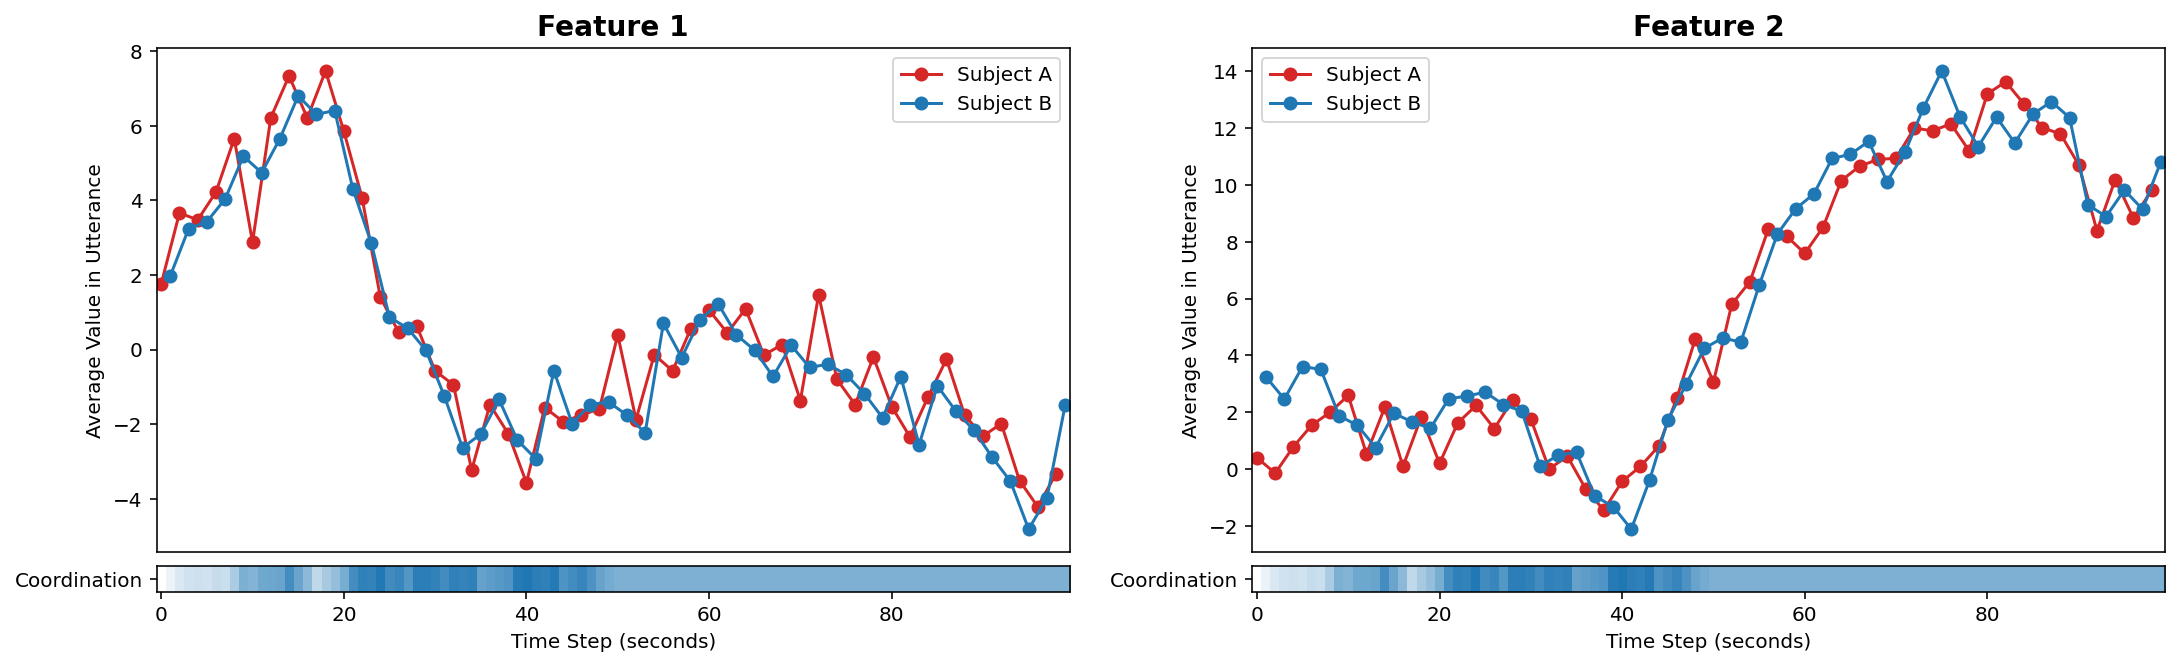

In [277]:
generator = VocalicsGeneratorForContinuousCoordination(coordination_series=continuous_cs,
                                                       num_vocalic_features=NUM_FEATURES,
                                                       time_scale_density=OBSERVATION_DENSITY,
                                                       mean_prior_a=MEAN_PRIOR_A,
                                                       mean_prior_b=MEAN_PRIOR_B,
                                                       std_prior_a=STD_PRIOR_A,
                                                       std_prior_b=STD_PRIOR_B,
                                                       std_coupling_a=STD_COUPLING_A,
                                                       std_coupling_b=STD_COUPLING_B)
vocalics_a, vocalics_b = generator.generate(SEED)

fig, axs = plt.subplots(1, 2, figsize=(18,5))
plot_vocalic_features(axs, vocalics_a, vocalics_b, ["Feature 1", "Feature 2"], False)
add_continuous_coordination_bar(main_ax=axs[0],
                                coordination_series=[continuous_cs],
                                coordination_colors=["tab:blue"],
                                labels=["Coordination"])
add_continuous_coordination_bar(main_ax=axs[1],
                                coordination_series=[continuous_cs],
                                coordination_colors=["tab:blue"],
                                labels=["Coordination"])

## Inference

Based on the observed vocalic series component, we can infer the coordination at each time step. The joint distribution of coordination and vocalics components is

$
\begin{align}
p(C_{0:T}, A_{0:T}, B_{0:T}, f) = p(C_0)\prod^{T}_{t=1}p(C_t|C_{t-1})p(A_t|A_{t-1}, B_{t-1}, C_t, f)p(B_t|B_{t-1},A_{t-1},C_t, f)
\end{align}
$

Notice that for a certain $t$, $A_t$ and $B_t$ might not have been observed, which means we do not include their terms in the equation above, or they are replaced by 1 which has the same effect. Also, $B_{t-1}$ and $A_{t-1}$ refer to the last time values for the series were observed, thus that might not correspond to the actual $t-1$ time step. 

Since all the distributions are Gaussians, inference here can be performed exactly using Kalman filter and Rauch–Tung–Striebel smoother.

The formulas were adapted from https://jwmi.github.io/ASM/6-KalmanFilter.pdf for the univariate case and our specific model formulation.

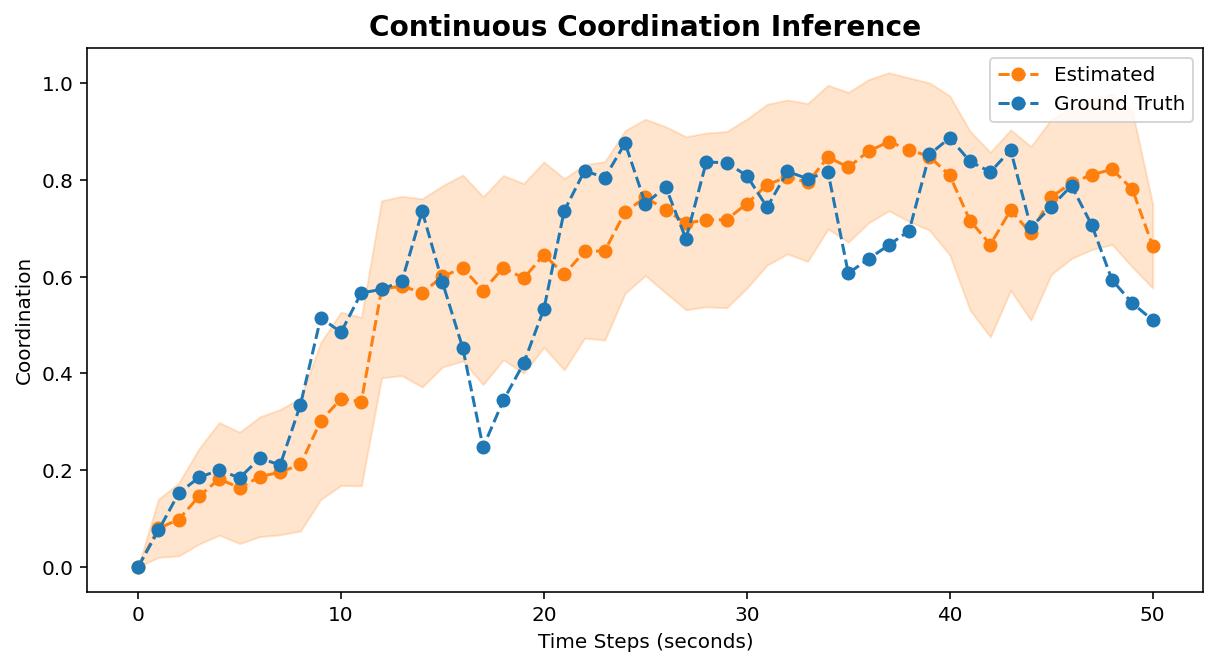

In [292]:
inference_engine = ContinuousCoordinationInferenceFromVocalics(series_a=vocalics_a, 
                                                               series_b=vocalics_b, 
                                                               mean_prior_coordination=MEAN_COORDINATION_PRIOR, 
                                                               std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                               std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                               mean_prior_a=MEAN_PRIOR_A,
                                                               mean_prior_b=MEAN_PRIOR_B,
                                                               std_prior_a=STD_PRIOR_A,
                                                               std_prior_b=STD_PRIOR_B,
                                                               std_coupling_a=STD_COUPLING_A,
                                                               std_coupling_b=STD_COUPLING_B)
params = inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(10, 5))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--", label='Estimated')
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
plt.plot(range(M+1), continuous_cs[0:M+1], marker="o", color="tab:blue", linestyle="--", label='Ground Truth')
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
plt.legend()